In [ ]:
# Jessica Gallo
# CSC 732 Pattern Recognition & Neural Networks
# Final Project Part 2
# Image Classification with Convolutional Neural Networks:
# Imbalance, Perform Evaluation, Ensembling

In [113]:
import os, shutil
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from sklearn import metrics
import random
from RMDL import RMDL_Image as RMDL

In [2]:
# ---------------
# Setting up GPU |
# ---------------

# anaconda prompt: activate tensorflow-gpu

from tensorflow.python.client import device_lib

# Checks to see available devices (CPU and GPU)
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

# Configures GPU Usage
print("Num GPUs Available: ", 
      len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [12]:
# --------------------------------------------------------------------------
# a                                                                        |          |
# Cut the original dataset if necessary and split the new one into three   |
# subsets: training set, validation set, and test set. Keep an approximate |
# ratio 70%-20%-10%. Make the following display of the three classes like  | 
# the graph shown below plus the numerical way                             |                                    |
# --------------------------------------------------------------------------

In [29]:
# returns a number of items inside the folder
def getNumber(path):
    s = 0
    for i in os.listdir(path):
        if i !='.DS_Store':
            s += len(os.listdir(os.path.join(path,i)))
    return s

# we use barplot a 4-5 times, made it as a function
def barPlot(x, y, title):
    fig, ax = plt.subplots()
    ax.bar(x, y)
    ax.set_xticklabels(x, rotation = 45)
    ax.set_title(title)
    plt.show()
    

# Function takes 4 parameters, filePath, name of the fruit, number of 
# instances on the folder and how many images you would like to create
# the function creates number_images/2 images blured and unsharp and 
# saves it on the same folder 
def createImage(pathToFolder, fruitName, maxNum, n):
    fnames = [os.path.join(pathToFolder, fname) for
          fname in os.listdir(pathToFolder)]
    for i in range(n//2):
        rand_tmp = random.randint(1, maxNum)
        img_path = fnames[rand_tmp]  #choosing an image to augment
        img = image.load_img(img_path, target_size = (320, 258))
        img=img.convert("RGB")
        r,g,b=img.split()
        r=r.convert("RGB")
        g=g.convert("RGB")
        b=b.convert("RGB")
        im_blur=img.filter(ImageFilter.GaussianBlur)
        im_unsharp=img.filter(ImageFilter.UnsharpMask)
        bl_name = fruitName+'_blur_'+str(i)+'.png'
        sh_name = fruitName+'_unsharp_'+str(i)+'.png'
        im_blur.save(pathToFolder + bl_name, 'PNG')
        im_unsharp.save(pathToFolder + sh_name, 'PNG')

In [4]:
# Function to count number of objects inside the directory
def getNumber(path):
    s = 0
    for i in os.listdir(path):
        if i !='.DS_Store':
            s += len(os.listdir(os.path.join(path,i)))
    return s

In [5]:
# Displaying the number of samples in each set (train/validation/test
train_dir = './Downloads/Data/training_set'
test_dir = './Downloads/Data/testing_set'
validation_dir = './Downloads/Data/validation_set'

# Get the number of samples in each directory
n_train = getNumber(train_dir)
n_test = getNumber(test_dir)
n_validation = getNumber(validation_dir)

Number of Samples Train: 12952
Number of Samples Validation: 4292
Number of Samples Test: 814


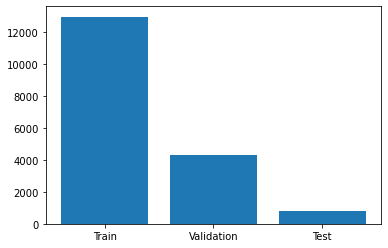

In [26]:
# Visualizing data

print('Number of Samples Train:', n_train)
print('Number of Samples Validation:', n_validation)
print('Number of Samples Test:', n_test)

fig, ax = plt.subplots()
ax.bar(['Train', 'Validation', 'Test'], [n_train, n_validation, n_test])
plt.show()

In [67]:
# Rescales all imaged by 1/255
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (320, 258),
    batch_size = 32,
    class_mode = 'categorical'
)


validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (320, 258),
    batch_size = 32,
    class_mode = 'categorical')

Found 12952 images belonging to 12 classes.
Found 4592 images belonging to 12 classes.


In [13]:
#-------------------------------------------------------------------------
# b                                                                      |
# Use Sequential model and build the topology of your CNN with not       |
# less than four convolutional layers. Use data normalization,           |
# batches and batch normalization, Glorot initialization, RELU           |
# activation function, shuffling, number of epochs not less than         |
# 50. All other elements as well as parameters of the CNN are up to you. |
# -----------------------------------------------------------------------

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu',
                        input_shape = (320, 258, 3),
                        kernel_initializer = 'glorot_normal',
                       bias_initializer = 'zeros'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(.5))
model.add(layers.Dense(512, activation='relu',
                       kernel_initializer = 'glorot_normal',
                       bias_initializer = 'zeros'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(12, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 318, 256, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 318, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 159, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 157, 126, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 78, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 76, 61, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 30, 128)       0

In [8]:
model.compile(loss = "categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=1e-4), 
              metrics = ["acc"])

In [9]:
history = model.fit_generator(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    shuffle = True)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 405 steps, validate for 135 steps
Epoch 1/50
405/405 [==============================] - 242s 597ms/step - loss: 0.9915 - acc: 0.6551 - val_loss: 0.9631 - val_acc: 0.6715
Epoch 2/50
405/405 [==============================] - 235s 580ms/step - loss: 0.3810 - acc: 0.8732 - val_loss: 0.2723 - val_acc: 0.9268
Epoch 3/50
405/405 [==============================] - 236s 582ms/step - loss: 0.2600 - acc: 0.9145 - val_loss: 0.2853 - val_acc: 0.9404
Epoch 4/50
405/405 [==============================] - 234s 578ms/step - loss: 0.1787 - acc: 0.9405 - val_loss: 0.2213 - val_acc: 0.9532
Epoch 5/50
405/405 [==============================] - 235s 581ms/step - loss: 0.1749 - acc: 0.9406 - val_loss: 0.2125 - val_acc: 0.9546
Epoch 6/50
405/405 [==============================] - 254s 627ms/step - loss: 0.1376 - acc: 0.9534 - val_loss: 0.2875 - val_acc: 0.9438
Epoch 7/50
405

In [10]:
# Saves model
model.save('fruit_categorical_adam_final.h5')

In [23]:
# ----------------------------------------------------------------------
# c                                                                    |
# Display the number of patterns in each class for the training and    |
# validation sets like in the example shown below. Do the same for the |
# test set as well. In this case both the training and validation sets |
# are imbalanced.                                                      |
# ----------------------------------------------------------------------

In [18]:
names = []
samples_train = []
samples_validation = []
samples_test = []

# Reading data
for i in os.listdir(train_dir):
    if i != '.DS_Store':
        names.append(i)
        samples_train.append(len(os.listdir(os.path.join(train_dir,i))))
        samples_validation.append(len(os.listdir(os.path.join(validation_dir,i))))
        samples_test.append(len(os.listdir(os.path.join(test_dir,i))))

Samples for Training Set: 
Apple: 1061 
Banana: 1027 
Carambola: 1031 
Guava: 1098 
Kiwi: 1161 
Mango: 1133 
Muskmelon: 1019 
Orange: 1115 
Peach: 1074 
Pear: 1092 
Persimmon: 1124 
Pitaya: 1017


c:\users\user\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


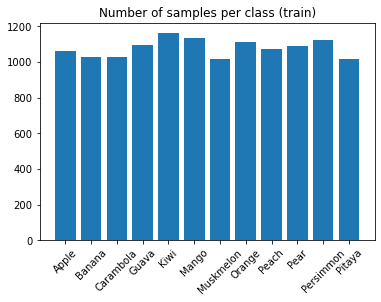

In [19]:
# Visualize train folder

print('Samples for Training Set:',
      '\nApple:', len(os.listdir('./Downloads/Data/training_set/Apple')),
      '\nBanana:', len(os.listdir('./Downloads/Data/training_set/Banana')),
      '\nCarambola:', len(os.listdir('./Downloads/Data/training_set/Carambola')),
      '\nGuava:', len(os.listdir('./Downloads/Data/training_set/Guava')),
      '\nKiwi:', len(os.listdir('./Downloads/Data/training_set/Kiwi')),
      '\nMango:', len(os.listdir('./Downloads/Data/training_set/Mango')),
      '\nMuskmelon:', len(os.listdir('./Downloads/Data/training_set/Muskmelon')),
      '\nOrange:', len(os.listdir('./Downloads/Data/training_set/Orange')),
      '\nPeach:', len(os.listdir('./Downloads/Data/training_set/Peach')),
      '\nPear:', len(os.listdir('./Downloads/Data/training_set/Pear')),
      '\nPersimmon:', len(os.listdir('./Downloads/Data/training_set/Persimmon')),
      '\nPitaya:', len(os.listdir('./Downloads/Data/training_set/Pitaya')))

fig, ax = plt.subplots()

ax.bar(names, samples_train)
ax.set_title("Number of samples per class (train)")
ax.set_xticklabels(names, rotation = 45)

fig.show()

Samples for Validation Set: 
Apple: 413 
Banana: 301 
Carambola: 312 
Guava: 399 
Kiwi: 392 
Mango: 419 
Muskmelon: 321 
Orange: 425 
Peach: 341 
Pear: 319 
Persimmon: 315 
Pitaya: 335


c:\users\user\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


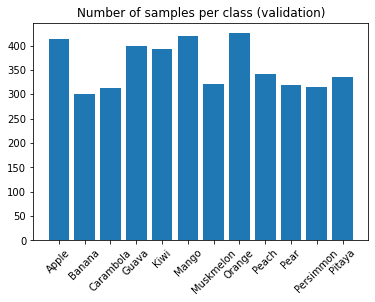

In [20]:
# Visualize validation folder

print('Samples for Validation Set:',
      '\nApple:', len(os.listdir('./Downloads/Data/validation_set/Apple')),
      '\nBanana:', len(os.listdir('./Downloads/Data/validation_set/Banana')),
      '\nCarambola:', len(os.listdir('./Downloads/Data/validation_set/Carambola')),
      '\nGuava:', len(os.listdir('./Downloads/Data/validation_set/Guava')),
      '\nKiwi:', len(os.listdir('./Downloads/Data/validation_set/Kiwi')),
      '\nMango:', len(os.listdir('./Downloads/Data/validation_set/Mango')),
      '\nMuskmelon:', len(os.listdir('./Downloads/Data/validation_set/Muskmelon')),
      '\nOrange:', len(os.listdir('./Downloads/Data/validation_set/Orange')),
      '\nPeach:', len(os.listdir('./Downloads/Data/validation_set/Peach')),
      '\nPear:', len(os.listdir('./Downloads/Data/validation_set/Pear')),
      '\nPersimmon:', len(os.listdir('./Downloads/Data/validation_set/Persimmon')),
      '\nPitaya:', len(os.listdir('./Downloads/Data/validation_set/Pitaya')))

fig, ax = plt.subplots()

ax.bar(names, samples_validation)
ax.set_title("Number of samples per class (validation)")
ax.set_xticklabels(names, rotation = 45)

fig.show()

Samples for Test Set: 
Apple: 69 
Banana: 70 
Carambola: 78 
Guava: 67 
Kiwi: 64 
Mango: 79 
Muskmelon: 62 
Orange: 63 
Peach: 64 
Pear: 65 
Persimmon: 69 
Pitaya: 64


c:\users\user\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


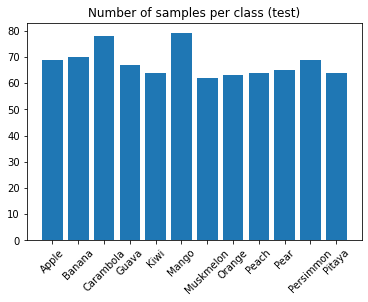

In [22]:
# Visualize test folder

print('Samples for Test Set:',
      '\nApple:', len(os.listdir('./Downloads/Data/testing_set/Apple')),
      '\nBanana:', len(os.listdir('./Downloads/Data/testing_set/Banana')),
      '\nCarambola:', len(os.listdir('./Downloads/Data/testing_set/Carambola')),
      '\nGuava:', len(os.listdir('./Downloads/Data/testing_set/Guava')),
      '\nKiwi:', len(os.listdir('./Downloads/Data/testing_set/Kiwi')),
      '\nMango:', len(os.listdir('./Downloads/Data/testing_set/Mango')),
      '\nMuskmelon:', len(os.listdir('./Downloads/Data/testing_set/Muskmelon')),
      '\nOrange:', len(os.listdir('./Downloads/Data/testing_set/Orange')),
      '\nPeach:', len(os.listdir('./Downloads/Data/testing_set/Peach')),
      '\nPear:', len(os.listdir('./Downloads/Data/testing_set/Pear')),
      '\nPersimmon:', len(os.listdir('./Downloads/Data/testing_set/Persimmon')),
      '\nPitaya:', len(os.listdir('./Downloads/Data/testing_set/Pitaya')))

fig, ax = plt.subplots()

ax.bar(names, samples_test)
ax.set_title("Number of samples per class (test)")
ax.set_xticklabels(names, rotation = 45)

fig.show()

In [ ]:
# -------------------------------------------------------------------------
# d                                                                       |
# Perform augmentation for only training and validation sets and for only |
# the underrepresented classes. Make the same display as above only for   |
# training and validation sets after augmentation. Do not implement       |
# augmentation for the test set                                           |
# -------------------------------------------------------------------------

In [ ]:
'''
From the graphs in part c, we can see that our training set is normalized. 
We don't have any class that hase considerably more samplese than the rest. 
However, in validation set 'Banana', 'Carambola', 'Muskmelon', 'Peach', 
'Pear', and 'Pitaya' have a little less data than the other classes. 
Therefore, we are going to add 50 augmented images in each above mentioned 
set. We randomly select an image from the set, and blur/unsharp image and 
save it under different name.
'''

Banana ---done creating image
Carambola ---done creating image
Muskmelon ---done creating image
Peach ---done creating image
Pear ---done creating image
Pitaya ---done creating image


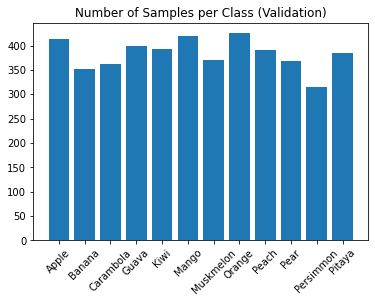

'\nit looks more normalized...\n'

In [32]:
under_class = ['Banana', 'Carambola', 'Muskmelon', 'Peach', 'Pear', 'Pitaya']

for names in under_class:
    createImage(validation_dir+'/'+names+'/', names, 280, 50)
    print(names, "---done creating image")


# re-plotting the number of samples in validation set
names = []
samples_validation = []

for i in os.listdir(train_dir):
    if i != '.DS_Store':
        names.append(i)
        samples_validation.append(len(os.listdir(os.path.join(validation_dir,i))))
        
# visualize validation folder
barPlot(names, samples_validation, 'Number of Samples per Class (Validation)')

'''
it looks more normalized...
'''

In [33]:
# --------------------------------------------------------------------------
# e                                                                        |
# Make experiments with three different optimizers by your choice (exclude |
# Gradient Descent and SGD with or without momentum) and plot the train    |
# and validation accuracy and train and validation loss (see the example   |
# below). Pick up the thickness of the lines so that the graphics are well |
# visible. Show the optimizer on the figures what is not done below.       |
# Increase the number of epochs if the learning accuracy shows the         |
# tendency of further increase.                                            |
# --------------------------------------------------------------------------

In [34]:
# before choosing an optimizer and training the model, we have to 
# convert images

datagen2 = ImageDataGenerator(rescale=1./255)

train_generator2 = datagen2.flow_from_directory(
    train_dir,
    target_size = (320, 258),
    batch_size = 32,
    class_mode = 'categorical'
)


validation_generator2 = datagen2.flow_from_directory(
    validation_dir,
    target_size = (320, 258),
    batch_size = 32,
    class_mode = 'categorical')

test_generator2 = datagen2.flow_from_directory(
    test_dir,
    target_size = (320,258),
    class_mode = 'categorical')

Found 12952 images belonging to 12 classes.
Found 4592 images belonging to 12 classes.
Found 814 images belonging to 12 classes.


In [35]:
# Model for RMSProp Optimizer
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3,3), activation='relu',
                        input_shape = (320, 258, 3),
                        kernel_initializer = 'glorot_normal',
                        bias_initializer = 'zeros'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(64, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(128, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(128, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(.5))
model2.add(layers.Dense(512, activation='relu',
                       kernel_initializer = 'glorot_normal',
                       bias_initializer = 'zeros'))
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(12, activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 318, 256, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 318, 256, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 159, 128, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 157, 126, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 78, 63, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 76, 61, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 38, 30, 128)      

In [36]:
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9)

model2.compile(loss = "categorical_crossentropy", 
               optimizer=rmsprop, 
               metrics=["acc"])

In [37]:
# Training model with rmsprop, 50 epochs and shuffling data
history_rsm = model2.fit_generator(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    shuffle = True)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 405 steps, validate for 135 steps
Epoch 1/50
405/405 [==============================] - 240s 594ms/step - loss: 1.5157 - acc: 0.5460 - val_loss: 1.3928 - val_acc: 0.4613
Epoch 2/50
405/405 [==============================] - 233s 574ms/step - loss: 0.7205 - acc: 0.7871 - val_loss: 0.6856 - val_acc: 0.8625
Epoch 3/50
405/405 [==============================] - 231s 571ms/step - loss: 0.5820 - acc: 0.8467 - val_loss: 0.9113 - val_acc: 0.7766
Epoch 4/50
405/405 [==============================] - 232s 574ms/step - loss: 0.5405 - acc: 0.8706 - val_loss: 0.7452 - val_acc: 0.8935
Epoch 5/50
405/405 [==============================] - 233s 576ms/step - loss: 0.4726 - acc: 0.8823 - val_loss: 0.8613 - val_acc: 0.8583
Epoch 6/50
405/405 [==============================] - 233s 575ms/step - loss: 0.4827 - acc: 0.8855 - val_loss: 0.8815 - val_acc: 0.9324
Epoch 7/50
405/405 [==============================] - 235s 579ms/step - loss: 0.4947 - acc

In [38]:
model2.save('fruit_categorical_rsmprop_final.h5')

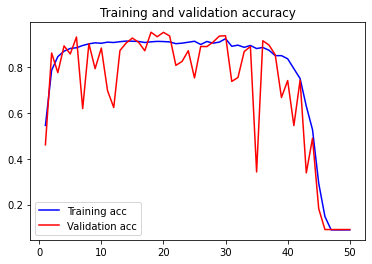

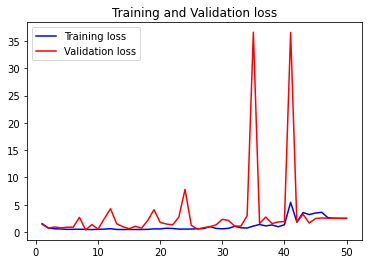

<Figure size 432x288 with 0 Axes>

In [40]:
# Visualizing train/validation loss and accuracy

acc_rsm = history_rsm.history['acc']
val_acc_rsm = history_rsm.history['val_acc']
loss_rsm = history_rsm.history['loss']
val_loss_rsm = history_rsm.history['val_loss']

epochs_rsm = range(1,len(acc_rsm) +1)

# Plot of accuracy
plt.plot(epochs_rsm, acc_rsm, color='blue', label='Training acc')
plt.plot(epochs_rsm, val_acc_rsm, color='red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot of loss
plt.plot(epochs_rsm, loss_rsm, color='blue', label='Training loss')
plt.plot(epochs_rsm, val_loss_rsm, color='red', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.figure()

plt.show()

In [41]:
datagen3 = ImageDataGenerator(rescale=1./255)

train_generator3 = datagen3.flow_from_directory(
    train_dir,
    target_size = (320, 258),
    batch_size = 32,
    class_mode = 'categorical'
)


validation_generator3 = datagen3.flow_from_directory(
    validation_dir,
    target_size = (320, 258),
    batch_size = 32,
    class_mode = 'categorical')

test_generator3 = datagen3.flow_from_directory(
    test_dir,
    target_size = (320,258),
    class_mode = 'categorical')

Found 12952 images belonging to 12 classes.
Found 4592 images belonging to 12 classes.
Found 814 images belonging to 12 classes.


In [48]:
# Model for Adagrad Optimizer
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3,3), activation='relu',
                        input_shape = (320, 258, 3),
                        kernel_initializer = 'glorot_normal',
                        bias_initializer = 'zeros'))
model3.add(layers.BatchNormalization())
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Conv2D(64, (3,3), activation='relu'))
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Conv2D(128, (3,3), activation='relu'))
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Conv2D(128, (3,3), activation='relu'))
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Flatten())
model3.add(layers.Dropout(.5))
model3.add(layers.Dense(512, activation='relu',
                       kernel_initializer = 'glorot_normal',
                       bias_initializer = 'zeros'))
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dense(12, activation='softmax'))
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 318, 256, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 318, 256, 32)      128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 159, 128, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 157, 126, 64)      18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 78, 63, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 76, 61, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 38, 30, 128)      

In [49]:
adagrad = optimizers.Adagrad(lr=0.01)

model3.compile(loss = "categorical_crossentropy", 
               optimizer=adagrad, 
               metrics=["acc"])

In [50]:
# Training model with adagrad, 50 epochs and shuffling data
history_adagrad = model3.fit_generator(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    shuffle = True)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 405 steps, validate for 135 steps
Epoch 1/50
405/405 [==============================] - 230s 568ms/step - loss: 1.2885 - acc: 0.5388 - val_loss: 1.1070 - val_acc: 0.5594
Epoch 2/50
405/405 [==============================] - 229s 565ms/step - loss: 0.5129 - acc: 0.8156 - val_loss: 0.4335 - val_acc: 0.8241
Epoch 3/50
405/405 [==============================] - 229s 565ms/step - loss: 0.3504 - acc: 0.8752 - val_loss: 0.2989 - val_acc: 0.9108
Epoch 4/50
405/405 [==============================] - 230s 567ms/step - loss: 0.2652 - acc: 0.9067 - val_loss: 0.2356 - val_acc: 0.9268
Epoch 5/50
405/405 [==============================] - 231s 570ms/step - loss: 0.2004 - acc: 0.9308 - val_loss: 0.2501 - val_acc: 0.9345
Epoch 6/50
405/405 [==============================] - 230s 568ms/step - loss: 0.1623 - acc: 0.9445 - val_loss: 0.1748 - val_acc: 0.9641
Epoch 7/50
405/405 [==============================] - 233s 576ms/step - loss: 0.1299 - acc

In [51]:
model2.save('fruit_categorical_adagrad_final.h5')

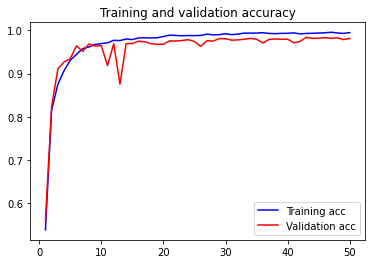

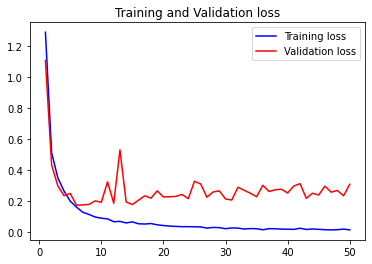

<Figure size 432x288 with 0 Axes>

In [52]:
# Visualizing train/validation loss and accuracy

acc_adagrad = history_adagrad.history['acc']
val_acc_adagrad = history_adagrad.history['val_acc']
loss_adagrad = history_adagrad.history['loss']
val_loss_adagrad = history_adagrad.history['val_loss']

epochs_adagrad = range(1,len(acc_adagrad) +1)

# Plot of accuracy
plt.plot(epochs_adagrad, acc_adagrad, color='blue', label='Training acc')
plt.plot(epochs_adagrad, val_acc_adagrad, color='red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot of loss
plt.plot(epochs_adagrad, loss_adagrad, color='blue', label='Training loss')
plt.plot(epochs_adagrad, val_loss_adagrad, color='red', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.figure()

plt.show()

In [69]:
# Rescales all imaged by 1/255
train_datagen4 = ImageDataGenerator(
    rescale= 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    horizontal_flip = True)
test_datagen4 = ImageDataGenerator(rescale=1./255)

train_generator4 = train_datagen4.flow_from_directory(
    train_dir,
    target_size = (320, 258),
    batch_size = 32,
    class_mode = 'categorical'
)


validation_generator4 = test_datagen4.flow_from_directory(
    validation_dir,
    target_size = (320, 258),
    batch_size = 32,
    class_mode = 'categorical')

Found 12952 images belonging to 12 classes.
Found 4592 images belonging to 12 classes.


In [54]:
# Model for Adam Optimizer
model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3,3), activation='relu',
                        input_shape = (320, 258, 3),
                        kernel_initializer = 'glorot_normal',
                       bias_initializer = 'zeros'))
model4.add(layers.BatchNormalization())
model4.add(layers.MaxPooling2D((2,2)))
model4.add(layers.Conv2D(64, (3,3), activation='relu'))
model4.add(layers.MaxPooling2D((2,2)))
model4.add(layers.Conv2D(128, (3,3), activation='relu'))
model4.add(layers.MaxPooling2D((2,2)))
model4.add(layers.Conv2D(128, (3,3), activation='relu'))
model4.add(layers.MaxPooling2D((2,2)))
model4.add(layers.Flatten())
model4.add(layers.Dropout(.5))
model4.add(layers.Dense(512, activation='relu',
                       kernel_initializer = 'glorot_normal',
                       bias_initializer = 'zeros'))
model4.add(layers.Dense(512, activation='relu'))
model4.add(layers.Dense(12, activation='softmax'))
model4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 318, 256, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 318, 256, 32)      128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 159, 128, 32)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 157, 126, 64)      18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 78, 63, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 76, 61, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 38, 30, 128)      

In [56]:
adam = optimizers.Adam(lr = 0.001, 
                       beta_1 = .9, 
                       beta_2 = .999, 
                       amsgrad = False, 
                       epsilon = 1e-08)

model4.compile(loss = "categorical_crossentropy", 
               optimizer=adam, 
               metrics = ["acc"])

In [57]:
history_adam = model4.fit_generator(
    train_generator4,
    epochs = 50,
    validation_data = validation_generator,
    shuffle = True)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 405 steps, validate for 135 steps
Epoch 1/50
405/405 [==============================] - 229s 565ms/step - loss: 1.2663 - acc: 0.5323 - val_loss: 1.1919 - val_acc: 0.5589
Epoch 2/50
405/405 [==============================] - 230s 567ms/step - loss: 0.6312 - acc: 0.7807 - val_loss: 0.4942 - val_acc: 0.8218
Epoch 3/50
405/405 [==============================] - 229s 566ms/step - loss: 0.4506 - acc: 0.8478 - val_loss: 0.8524 - val_acc: 0.7120
Epoch 4/50
405/405 [==============================] - 229s 566ms/step - loss: 0.3618 - acc: 0.8855 - val_loss: 0.6914 - val_acc: 0.7759
Epoch 5/50
405/405 [==============================] - 230s 567ms/step - loss: 0.3263 - acc: 0.8930 - val_loss: 0.9576 - val_acc: 0.7241
Epoch 6/50
405/405 [==============================] - 230s 568ms/step - loss: 0.2712 - acc: 0.9139 - val_loss: 0.4118 - val_acc: 0.8802
Epoch 7/50
405/405 [==============================] - 232s 572ms/step - loss: 0.2149 - acc

In [58]:
model2.save('fruit_categorical_adam_diff_final.h5')

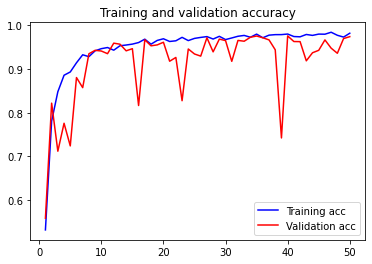

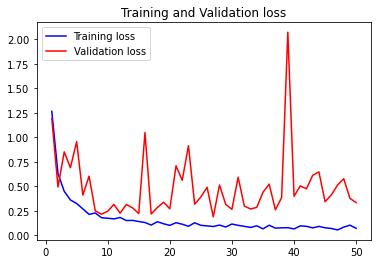

<Figure size 432x288 with 0 Axes>

In [59]:
# Visualizing train/validation loss and accuracy

acc_adam = history_adam.history['acc']
val_acc_adam = history_adam.history['val_acc']
loss_adam = history_adam.history['loss']
val_loss_adam = history_adam.history['val_loss']

epochs_adam = range(1,len(acc_adam) +1)

# Plot of accuracy
plt.plot(epochs_adam, acc_adam, color='blue', label='Training acc')
plt.plot(epochs_adam, val_acc_adam, color='red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot of loss
plt.plot(epochs_adam, loss_adam, color='blue', label='Training loss')
plt.plot(epochs_adam, val_loss_adam, color='red', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.figure()

plt.show()

In [ ]:
# --------------------------------------------------------------------------
# f                                                                        |
# Evaluate the performance of each implemented by you optimizer using the  |
# test set. Display the normalized confusion matrix, precision, recall,    |
# F1-score, support. Draw ROC and AUC.                                     |
# --------------------------------------------------------------------------

In [121]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

datagen = ImageDataGenerator(rescale=1./255)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size = (320,258),
    class_mode = 'categorical')

# precision
steps = np.math.ceil(test_generator.samples/16)

# recall
predictions = model.predict_generator(test_generator, steps=steps)

predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test_generator.classes
class_label = list(test_generator.class_indices.keys())

# report
report = metrics.classification_report(true_classes, 
                                       predicted_classes, 
                                       target_names=class_label)

print(report)

# confusion matrix
cm = metrics.confusion_matrix(true_classes, predicted_classes)
print(cm)

Found 814 images belonging to 12 classes.


AttributeError: 'LogisticRegression' object has no attribute 'predict_generator'

In [120]:
# ROC AUC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate 2 class dataset
#load the model
classifierLoad = tf.keras.models.load_model('./Documents/fruit_categorical_adam_diff_final.h5')

X, y = classifierLoad(n_samples=1000, n_classes=2, random_state=1)

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)

# predict probabilities
lr_probs = model.predict_proba(testX)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

TypeError: __call__() missing 1 required positional argument: 'inputs'

In [ ]:
# ------------------------------------------------------------------
# g  |
# Visualize several channels in some intermediate activations and 
# display at least 12 images from the test set with correct and 
# wrong predictions
# ------------------------------------------------------------------

Image tensor shape:  (1, 320, 258, 3)


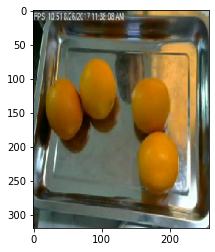

In [63]:
img_path = "./Downloads/Data/testing_set/Orange/Orange001923.png"

img1 = image.load_img(img_path, target_size = (320, 258))
img_tensor = image.img_to_array(img1)
img_tensor = np.expand_dims(img_tensor, axis = 0)

img_tensor /= 255.

print("Image tensor shape: ", img_tensor.shape)

#display the test image

plt.imshow(img_tensor[0])
plt.show()

n_col: 2


c:\users\user\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


n_col: 2
n_col: 2
n_col: 4
n_col: 4
n_col: 8
n_col: 8
n_col: 8


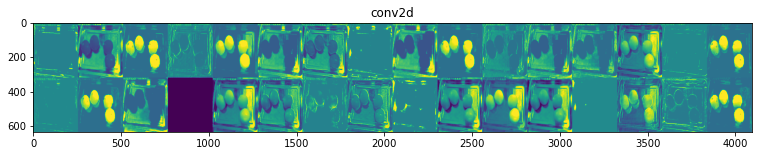

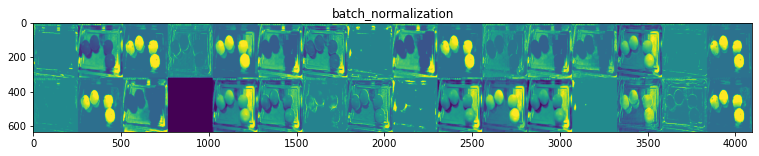

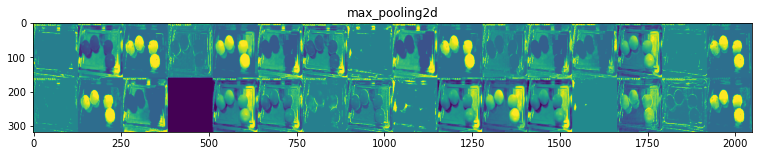

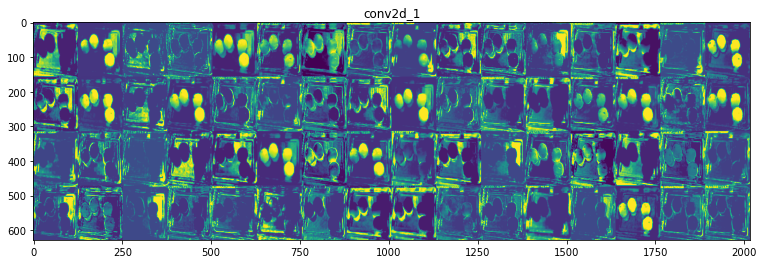

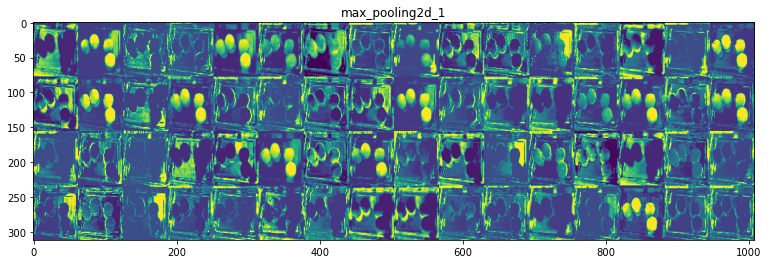

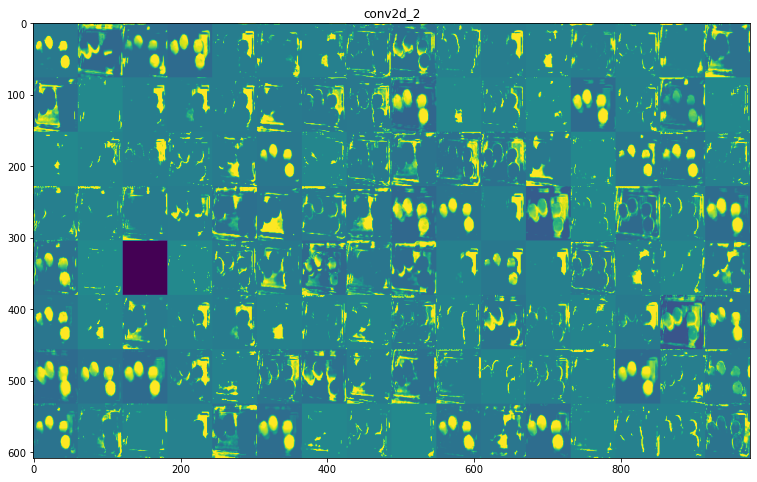

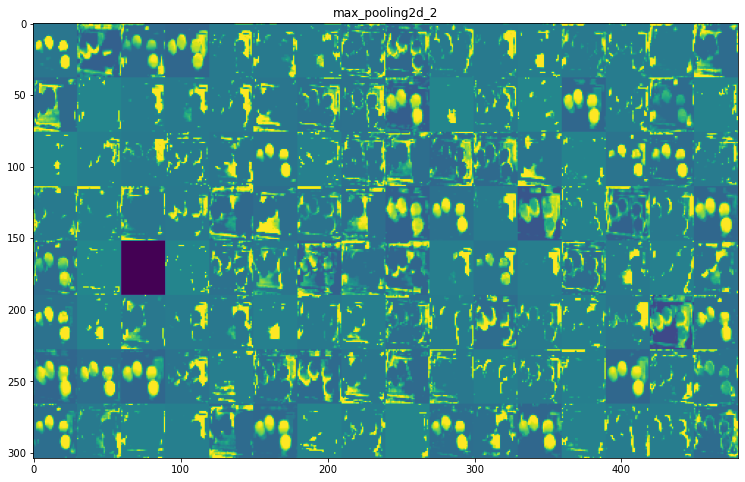

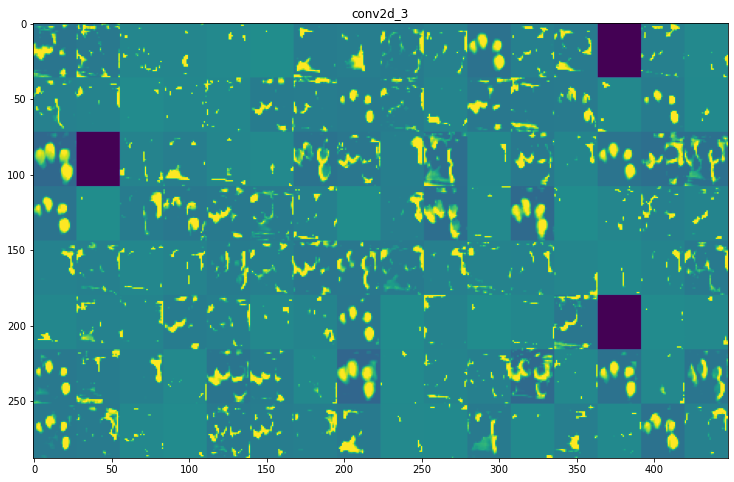

In [64]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)

activations = activation_model.predict(img_tensor) #returns a list of five numpy arrays


# name of the layers..

layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    size2 = layer_activation.shape[2]
    n_cols = n_features // images_per_row
    
    display_grid = np.zeros((size * n_cols, images_per_row * size2))
    print("n_col:", n_cols)
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image +=128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
           # print("col: ", col)
            #print("row: ", row)
            #print("size: ", size)
            display_grid[col * size : (col+1) * size,
                         row * size2 : (row + 1) * size2] = channel_image
            
    scale = 1./ size
    plt.figure(figsize = (scale * display_grid.shape[1],
                          scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

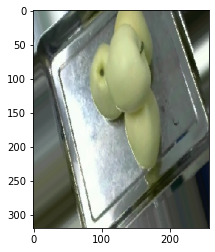

Actual value:  0 	Predicted value:  0


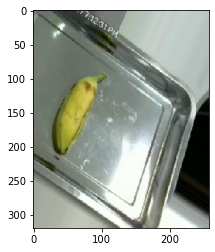

Actual value:  1 	Predicted value:  1


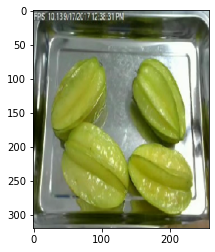

Actual value:  2 	Predicted value:  2


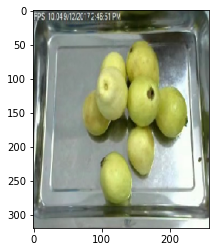

Actual value:  3 	Predicted value:  3


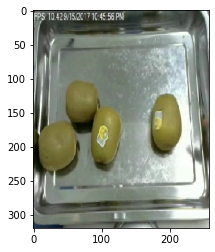

Actual value:  4 	Predicted value:  4


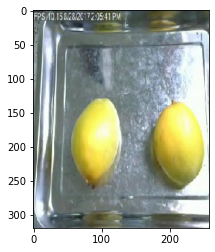

Actual value:  5 	Predicted value:  5


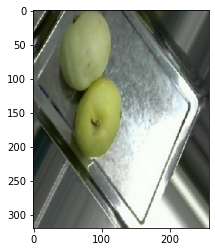

Actual value:  6 	Predicted value:  6


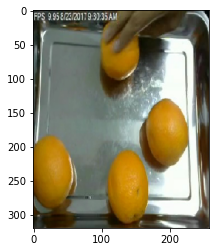

Actual value:  7 	Predicted value:  7


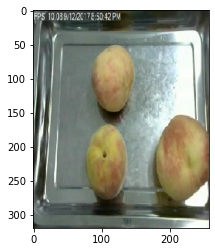

Actual value:  8 	Predicted value:  8


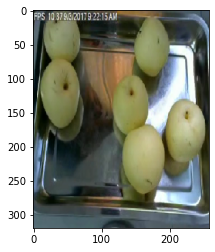

Actual value:  9 	Predicted value:  9


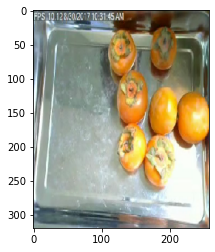

Actual value:  10 	Predicted value:  10


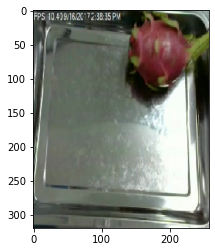

Actual value:  11 	Predicted value:  11


In [65]:
# displaying 12 images with the prediction -----------

# we chose 1 image from each class...

labels = ['Apple', 'Banana', 'Carambola', 'Guava', 'Kiwi',
          'Mango', 'Muskmelon', 'Orange', 'Peach', 'Pear',
          'Persimmon', 'Pitaya']
i=0
for names in labels:
    pathToFolder = test_dir +'/'+names+'/'
    fnames = [os.path.join(pathToFolder, fname) for
          fname in os.listdir(pathToFolder)]
    
    # generate random number btwn (0,50)
    randNum = random.randint(0, 50)
    img_path = fnames[randNum]
    tmp_img = image.load_img(img_path, target_size = (320, 258))
    tmp_img = image.img_to_array(tmp_img)
    tmp_img = np.expand_dims(tmp_img, axis = 0)
    
    tmp_img /=255.
    plt.imshow(tmp_img[0])
    plt.show()
    # predict 
    result = model.predict(tmp_img)
    train_generator.class_indices
    print('Actual value: ',i,'\tPredicted value: ', np.argmax(result))
    i+=1

In [ ]:
# ----------------------------------------------------------------------
# h
# Build ensemble based on the results of implemented by you optimizers 
# and evaluate the ensemble performance.
# ----------------------------------------------------------------------

In [116]:
# RMDL Ensemble

# Adam Optimizer Model
#load the model
classifierLoad = tf.keras.models.load_model('./Documents/fruit_categorical_adam_diff_final.h5')

'''
Image_Classification(x_train, y_train, x_test, y_test, shape, batch_size=128,
                     sparse_categorical=True, random_deep=[3, 3, 3], epochs=[500, 500, 500], plot=True,
                     min_hidden_layer_dnn=1, max_hidden_layer_dnn=8, min_nodes_dnn=128, max_nodes_dnn=1024,
                     min_hidden_layer_rnn=1, max_hidden_layer_rnn=5, min_nodes_rnn=32, max_nodes_rnn=128,
                     min_hidden_layer_cnn=3, max_hidden_layer_cnn=10, min_nodes_cnn=128, max_nodes_cnn=512,
                     random_state=42, random_optimizor=True, dropout=0.05)
'''
for X_train, y_train, X_test, y_test in model_rmdl_adam:
    X_train_D = X_train.reshape(X_train.shape[0], (320, 258, 3)).astype('float32')
    X_test_D = X_test.reshape(X_test.shape[0], (320, 258, 3)).astype('float32')
    X_train = X_train_D / 255.0
    X_test = X_test_D / 255.0
    number_of_classes = np.unique(y_train).shape[0]
    shape = (320, 258, 3)

batch_size = 128
sparse_categorical = 0
n_epochs = [100, 100, 100]  ## DNN-RNN-CNN
Random_Deep = [3, 3, 3]  ## DNN-RNN-CNN
RMDL.Image_Classification(X_train, y_train, X_test, y_test, batch_size, 
                          shape, sparse_categorical, Random_Deep, n_epochs)

TypeError: 'Sequential' object is not iterable

In [115]:
from keras.models import load_model

# load pre-trained ensemble members
models = list()
# load model
classifierLoad = tf.keras.models.load_model('./Documents/fruit_categorical_adam_diff_final.h5')
# store in memory
models.append(classifierLoad)

# make predictions
yhats = [classifierLoad.predict(testX) for classifierLoad in models]
yhats = array(yhats)
# calculate average
outcomes = mean(yhats)

# make predictions
yhats = [classifierLoad.predict_classes(testX) for classifierLoad in models]
yhats = array(yhats)
# calculate mode
outcomes, _ = mode(yhats)

# make predictions
yhats = [classifierLoad.predict(testX) for classifierLoad in models]
yhats = array(yhats)
# sum across ensembles
summed = numpy.sum(yhats, axis=0)
# argmax across classes
outcomes = argmax(summed, axis=1)

ValueError: Error when checking input: expected conv2d_4_input to have 4 dimensions, but got array with shape (350, 2)

In [118]:
import pandas as pd


# this function return the max number of classes predicted per each test case.

def countMax(df):
    arr = np.asarray(df)
    cnt_arr = [0,0,0]
    for i in range(df.shape[0]):
        cnt_arr[i] += 1
        for j in range(i+1,df.shape[0]):
            if arr[i] == arr[j]:
                cnt_arr[i] +=1
    #print('index: ', np.argmax(cnt_arr, axis =1))
    #print(cnt_arr)
    #print(arr[0])
    return arr[cnt_arr.index(max(cnt_arr))]

#load the model---- you don't have to do this (this is not the model we trained)
# these models don't have any weight, use the models you trained
model1 = load_model('./Documents/fruit_categorical_adam_diff_final.h5', compile = False)
model2 = load_model('./Documentsfruit_categorical_adagrad_final.h5', compile = False)
model3 = load_model('./Documents/fruit_categorical_rsmprop_final.h5', compile = False)


# and i assume you don't need this part either, i just needed some data to work with
# these are predicted values for each model....
pred_model1  = model1.predict_generator(test_generator, steps = steps)
pred_model1 = np.argmax(pred_model1, axis = 1)
print("pred 1: ", pred_model1[:4])


pred_model2  = model2.predict_generator(test_generator, steps = steps)
pred_model2 = np.argmax(pred_model2, axis = 1)
print("pred 2: ", pred_model2[:4])


pred_model3  = model3.predict_generator(test_generator, steps = steps)
pred_model3 = np.argmax(pred_model3, axis = 1)
# --------------------


# combine predictions... i am trying to code weighted average..
predictions = {'model1' : pred_model1, 'model2' : pred_model2, 'model3': pred_model3}
predictions_df = pd.DataFrame(data = predictions)
print(predictions_df.shape)

# i will save the majority predictions in this array..
# you can use it to show F-1 score, accuracy etc. as in part F...
majority_pred = []


# loop through all the models, and save the mst commont answer
for i in range(50):
    majority_pred.append(countMax(predictions_df.iloc[i]))


ValueError: Unknown initializer: GlorotNormal